In [1]:
import data
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.special import logsumexp

In [2]:
train_data, train_labels, test_data, test_labels = data.load_all_data_from_zip('a4digits.zip', 'data')
accuracy = lambda predicted_labels, actual_labels: sum(predicted_labels == actual_labels) / len(actual_labels)

## Conditional Gaussian Classifier

In [4]:
def compute_mean_mles(train_data, train_labels):
    '''
    Compute the mean estimate for each digit class
    '''
    means = np.array([train_data[train_labels == i].mean(axis=0) for i in range(10)])
    return means


def compute_sigma_mles(train_data, train_labels):
    '''
    Compute the covariance estimate for each digit class
    '''
    means = compute_mean_mles(train_data, train_labels)
    covariances = []
    for i in range(10):
        X = train_data[train_labels == i]
        sigma = []
        for j in range(len(X)):
            a = (X[j] - means[i]).reshape(64, 1)
            b = a.T
            sigma.append(a * b)
        covariances.append(np.array(sigma).sum(axis=0) / len(X) + np.identity(64) * .01)
    return np.array(covariances)


def plot_cov_diagonal(covariances):
    # Plot the log-diagonal of each covariance matrix side by side
    all_concat = np.concatenate([np.log(np.diag(covariances[i])).reshape(8,8) for i in range(10)], 1)
    plt.imshow(all_concat, cmap='gray')
    plt.show()

def generative_likelihood(digits, means, covariances):
    '''
    Compute the generative log-likelihood:
        log p(x|y,mu,Sigma)
    '''
    
    return np.array([[np.log(multivariate_normal.pdf(digits[j], means[i], covariances[i])) for i in range(10)] 
                     for j in range(len(digits))])

def conditional_likelihood(digits, means, covariances):
    '''
    Compute the conditional likelihood:

        log p(y|x, mu, Sigma)
    '''
    generative_likelihoods = generative_likelihood(digits, means, covariances)
    posterior = generative_likelihoods - np.log(np.exp(generative_likelihoods).sum(axis=1).reshape((len(digits), 1)))
    return posterior

def avg_conditional_likelihood(digits, labels, means, covariances):
    '''
    Compute the average conditional likelihood over the true class labels

        AVG( log p(y_i|x_i, mu, Sigma) )
    '''
    cond_likelihood = conditional_likelihood(digits, means, covariances)
    true_class_likelihoods = []
    for i, likelihoods in enumerate(cond_likelihood):
        true_class_likelihoods.append(likelihoods[int(labels[i])])
    return np.array(true_class_likelihoods).mean()

def classify_data(digits, means, covariances):
    '''
    Classify new points by taking the most likely posterior class
    '''
    cond_likelihood = conditional_likelihood(digits, means, covariances)
    return np.array([np.argmax(cl) for cl in cond_likelihood])



### Plotting the variances of class k's features

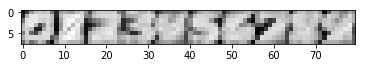

In [5]:
means = compute_mean_mles(train_data, train_labels)
covariances = compute_sigma_mles(train_data, train_labels)
plot_cov_diagonal(covariances)

### Average conditional likelihoods for the training and test data 

In [6]:
avg_conditional_likelihood(train_data, train_labels, means, covariances)

-0.12462443666862952

In [7]:
avg_conditional_likelihood(test_data, test_labels, means, covariances)

-0.19667320325525503

### Accuracy score for the training and test data

In [8]:
predicted_test_labels = classify_data(test_data, means, covariances)
accuracy(predicted_test_labels, test_labels)

0.97275

In [9]:
predicted_train_labels = classify_data(train_data, means, covariances)
accuracy(predicted_train_labels, train_labels)

0.9814285714285714